不動産価格予測

In [1]:
# ご自身のパスを設定
YOUR_PATH = "/content/drive/MyDrive/Colab Notebooks/nishika-mantion-summer"

In [2]:
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from itertools import product
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OrdinalEncoder

## 実行環境の情報

dataディレクトリ配下に以下のようにデータを格納しているとする

├─ input<br>
│   ├─ data_explanation.xlsx<br>
│   ├─ sample_submission.csv<br>
│   ├─ test.csv<br>
│   └─ train<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 01.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 02.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 03.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ ...<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└─ 47.csv<br>
└─ output


メモリサイズ(GB)

In [3]:
!cat /proc/meminfo | awk '($1=="MemTotal:") {print $2/1048576}'

15.4698


Pythonバージョン

In [4]:
!python -V

Python 3.11.4


Pythonライブラリ情報

In [5]:
!pip freeze

aiobotocore @ file:///croot/aiobotocore_1682536655331/work
aiofiles @ file:///croot/aiofiles_1683773582346/work
aiohttp @ file:///work/ci_py311/aiohttp_1676827623103/work
aioitertools @ file:///tmp/build/80754af9/aioitertools_1607109665762/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
aiosqlite @ file:///croot/aiosqlite_1683773899903/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
alembic==1.12.0
anaconda-catalogs @ file:///croot/anaconda-catalogs_1685727283692/work
anaconda-client==1.12.0
anaconda-navigator==2.4.2
anaconda-project @ file:///work/ci_py311/anaconda-project_1676846728333/work
annotated-types==0.5.0
anyio @ file:///work/ci_py311/anyio_1676823771847/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///work/ci_py311/argon2-cffi-bindings_1676823553406/work
arrow @ file:///work/ci_py311/arrow_1677696236099/work
astroid @ file:///work/ci_py311/astroid

## 前処理

In [6]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(float(moyori))
    return moyori

In [7]:
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

In [8]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [13]:
BASE_PATH = '../'

In [14]:
paths = glob(BASE_PATH + 'input/train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'input/test.csv')

/tmp/ipykernel_1766/1230373460.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
/tmp/ipykernel_1766/1230373460.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
/tmp/ipykernel_1766/1230373460.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
/tmp/ipykernel_1766/1230373460.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)


In [15]:
train_df.shape

(779404, 28)

In [16]:
train_df.isnull().sum()

ID                   0
種類                   0
地域              779404
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                672
最寄駅：名称            2796
最寄駅：距離（分）        23222
間取り              29150
面積（㎡）                0
土地の形状           779404
間口              779404
延床面積（㎡）         779404
建築年              22792
建物の構造            22320
用途               85676
今後の利用目的         368194
前面道路：方位         779404
前面道路：種類         779404
前面道路：幅員（ｍ）      779404
都市計画             20670
建ぺい率（％）          25309
容積率（％）           25309
取引時点                 0
改装               76361
取引の事情等          760032
取引価格（総額）_log         0
dtype: int64

In [17]:
sub_df = pd.read_csv(BASE_PATH + 'input/sample_submission.csv')

In [18]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

### 不要なカラムの削除

In [20]:
df = pd.concat([train_df, test_df])

rm_cols += ['市区町村コード']
for i,v in df.nunique().items():
    if v <= 1:
        rm_cols.append(i)

rm_cols

['市区町村コード',
 '市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [22]:
test_df[TARGET] = np.nan
train_df.drop(rm_cols, axis=1, inplace=True)
test_df.drop(rm_cols, axis=1, inplace=True)
df = pd.concat([train_df, test_df])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

KeyError: "['市区町村コード', '市区町村コード', '種類', '地域', '土地の形状', '間口', '延床面積（㎡）', '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）'] not found in axis"

In [ ]:
df['取引時点'].unique()

array(['2005年第3四半期', '2005年第4四半期', '2006年第1四半期', '2006年第2四半期',
       '2006年第3四半期', '2006年第4四半期', '2007年第1四半期', '2007年第2四半期',
       '2007年第3四半期', '2007年第4四半期', '2008年第1四半期', '2008年第2四半期',
       '2008年第3四半期', '2008年第4四半期', '2009年第1四半期', '2009年第2四半期',
       '2009年第3四半期', '2009年第4四半期', '2010年第1四半期', '2010年第2四半期',
       '2010年第3四半期', '2010年第4四半期', '2011年第1四半期', '2011年第2四半期',
       '2011年第3四半期', '2011年第4四半期', '2012年第1四半期', '2012年第2四半期',
       '2012年第3四半期', '2012年第4四半期', '2013年第1四半期', '2013年第2四半期',
       '2013年第3四半期', '2013年第4四半期', '2014年第1四半期', '2014年第2四半期',
       '2014年第3四半期', '2014年第4四半期', '2015年第1四半期', '2015年第2四半期',
       '2015年第3四半期', '2015年第4四半期', '2016年第1四半期', '2016年第2四半期',
       '2016年第3四半期', '2016年第4四半期', '2017年第1四半期', '2017年第2四半期',
       '2017年第3四半期', '2017年第4四半期', '2018年第1四半期', '2018年第2四半期',
       '2018年第3四半期', '2018年第4四半期', '2019年第1四半期', '2019年第2四半期',
       '2019年第3四半期', '2019年第4四半期', '2020年第1四半期', '2020年第2四半期',
       '2020年第3四半期', '2020年第4四半期', '2021年第1四半期', '2021年

In [ ]:
df[df['取引時点'].str.contains('202年第1四半期|2022年第2四半期')]

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
765716,13323516,東京都,葛飾区,白鳥,お花茶屋,9,３ＬＤＫ,70,令和3年,ＲＣ,住宅,住宅,工業地域,60.0,400.0,2022年第2四半期,未改装,NaN,7.716003
765717,13017325,東京都,新宿区,市谷田町,市ケ谷,8,３ＬＤＫ,70,平成12年,ＲＣ,住宅,住宅,第１種住居地域,60.0,300.0,2022年第2四半期,改装済,NaN,7.963788
765718,44005040,大分県,大分市,高城新町,高城,2,４ＬＤＫ,95,平成14年,ＳＲＣ,NaN,住宅,商業地域,80.0,400.0,2022年第2四半期,未改装,NaN,7.278754
765719,43002630,熊本県,熊本市中央区,新屋敷,新水前寺,18,３ＬＤＫ,70,平成16年,ＲＣ,住宅,住宅,近隣商業地域,80.0,300.0,2022年第2四半期,改装済,NaN,7.447158
765720,13074631,東京都,江東区,豊洲,豊洲,9,３ＬＤＫ,55,昭和55年,ＳＲＣ,住宅,住宅,準工業地域,60.0,300.0,2022年第2四半期,未改装,NaN,7.518514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779399,27004878,大阪府,大阪市西区,江之子島,阿波座,4,２ＬＤＫ,60,昭和57年,ＳＲＣ,住宅,住宅,商業地域,80.0,800.0,2022年第2四半期,未改装,NaN,7.278754
779400,26010558,京都府,京都市下京区,修徳学区,五条(京都市営),2,１Ｋ,20,昭和64年,鉄骨造,住宅,住宅,商業地域,80.0,700.0,2022年第2四半期,未改装,NaN,6.792392
779401,26026833,京都府,京都市西京区,桂稲荷山町,桂,10,３ＬＤＫ,65,昭和59年,ＲＣ,NaN,住宅,第２種住居地域,60.0,300.0,2022年第2四半期,NaN,NaN,7.255273
779402,26042848,京都府,城陽市,平川,久津川,2,２ＬＤＫ,70,平成7年,ＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2022年第2四半期,改装済,NaN,7.380211


In [23]:
val_min_idx = min(df[df['取引時点'].str.contains('2022年第1四半期|2022年第2四半期', regex=True)].index) # 該当の取引時点のindexを引っ張ってくる
test_min_idx = min(df[df['取引時点'].str.contains('2022年第3四半期|2022年第4四半期', regex=True)].index)
val_min_idx, test_min_idx

(751910, 779404)

In [24]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2022年第1四半期', '2022年第2四半期'}

In [25]:
# 2005年第3四半期 なら 0 , 2005年第4四半期 なら2 ・・・ と採番
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)



In [27]:
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

# 特定の期間以下の範囲で 各都道府県の販売価格の平均を取る(累計) ex ～20**年第◯四半期までの平均
for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()


In [28]:
te_dic[50] # 50番目の取引時期"までの"都道府県ごとの販売価格平均

{'三重県': 7.099989772836439,
 '京都府': 7.155935848555253,
 '佐賀県': 7.009937258263509,
 '兵庫県': 7.157742870483196,
 '北海道': 6.965967793677859,
 '千葉県': 7.155825324964995,
 '和歌山県': 7.022690210815773,
 '埼玉県': 7.1697442713966355,
 '大分県': 6.911537826573079,
 '大阪府': 7.158352973821201,
 '奈良県': 7.056884610234688,
 '宮城県': 7.0395442538048805,
 '宮崎県': 6.958678653711235,
 '富山県': 7.0469200713870155,
 '山口県': 7.045342730349803,
 '山形県': 7.087990602814902,
 '山梨県': 6.848839888686708,
 '岐阜県': 7.078095913486453,
 '岡山県': 7.03809073492747,
 '岩手県': 6.925002679060599,
 '島根県': 7.165376214700312,
 '広島県': 7.093449021655064,
 '徳島県': 6.912051981629745,
 '愛媛県': 6.966433011596662,
 '愛知県': 7.107301969238601,
 '新潟県': 6.913835156235044,
 '東京都': 7.377929204641064,
 '栃木県': 6.950636958071011,
 '沖縄県': 7.160046604428336,
 '滋賀県': 7.16602695816839,
 '熊本県': 6.970182251843263,
 '石川県': 6.929363348877185,
 '神奈川県': 7.2581182672098175,
 '福井県': 6.979575815840195,
 '福岡県': 6.992264905042226,
 '福島県': 6.9743805791401785,
 '秋田県': 6.9413137471126

In [29]:
# 先程作成した、te_dicを 各行に対して列追加していく
# 1行目であれば、東京都における、第1四半期より前までの全期間の平均を追加する。（取引時点_enc=0のときはデータがないので0になるけど。）

def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df[group_col+'_te'] = df.apply(calc_te, axis=1)
df.head(2)

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,...,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
0,13288382,東京都,中野区,上高田,落合(東京),NaN,２ＤＫ,40,平成17年,ＲＣ,...,NaN,第１種低層住居専用地域,60.0,150.0,2005年第3四半期,NaN,NaN,7.531479,0,0.0
1,13101684,東京都,新宿区,高田馬場,高田馬場,NaN,２ＬＤＫ,55,平成17年,NaN,...,NaN,第１種中高層住居専用地域,60.0,300.0,2005年第3四半期,未改装,NaN,7.568202,0,0.0


In [30]:
# 例えば、 以下のように、 千葉、で 取引時点22年第4四半期 までの取引価格の平均は、7.172022..なので、それが入る
print(te_dic[69]['千葉県'])
df.tail()

7.1720221576584064


,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,...,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
797793,12165026,千葉県,四街道市,大日,四街道,25,３ＬＤＫ,60,平成7年,ＲＣ,...,住宅,第１種中高層住居専用地域,60.0,200.0,2022年第4四半期,未改装,調停・競売等,NaN,69,7.172022
797794,12165685,千葉県,四街道市,中央,四街道,8,３ＬＤＫ,75,平成21年,ＲＣ,...,住宅,第１種住居地域,60.0,200.0,2022年第4四半期,未改装,NaN,NaN,69,7.172022
797795,27032212,大阪府,大阪市住吉区,長居西,長居,9,２ＬＤＫ,65,平成3年,鉄骨造,...,住宅,第２種中高層住居専用地域,60.0,200.0,2022年第4四半期,未改装,NaN,NaN,69,7.193511
797796,27029577,大阪府,大阪市阿倍野区,阪南町,文の里,3,NaN,60,昭和59年,ＲＣ,...,住宅,第１種住居地域,80.0,300.0,2022年第4四半期,NaN,NaN,NaN,69,7.193511
797797,14009638,神奈川県,横浜市神奈川区,菅田町,片倉町,24,２ＬＤＫ,45,昭和46年,ＲＣ,...,住宅,第１種中高層住居専用地域,60.0,150.0,2022年第4四半期,改装済,NaN,NaN,69,7.277045


In [31]:
df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4])) # 2021からみて何年前に取引されたか? 2021になにかあった?
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

In [32]:
df

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,...,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,13288382,東京都,中野区,上高田,落合(東京),NaN,２ＤＫ,40,2005.0,ＲＣ,...,NaN,第１種低層住居専用地域,60.0,150.0,NaN,NaN,7.531479,0,0.000000,16
1,13101684,東京都,新宿区,高田馬場,高田馬場,NaN,２ＬＤＫ,55,2005.0,NaN,...,NaN,第１種中高層住居専用地域,60.0,300.0,未改装,NaN,7.568202,0,0.000000,16
2,23226945,愛知県,名古屋市昭和区,広路通,御器所,8.0,３ＬＤＫ,70,1995.0,ＲＣ,...,NaN,近隣商業地域,80.0,300.0,改装済,NaN,7.447158,0,0.000000,16
3,13387394,東京都,板橋区,若木,上板橋,16.0,３ＤＫ,50,1969.0,ＲＣ,...,NaN,第１種中高層住居専用地域,60.0,200.0,未改装,NaN,7.146128,0,0.000000,16
4,14328549,神奈川県,川崎市多摩区,三田,生田(神奈川),6.0,２ＤＫ,45,1967.0,ＲＣ,...,NaN,NaN,NaN,NaN,未改装,調停・競売等,6.763428,0,0.000000,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797793,12165026,千葉県,四街道市,大日,四街道,25.0,３ＬＤＫ,60,1995.0,ＲＣ,...,住宅,第１種中高層住居専用地域,60.0,200.0,未改装,調停・競売等,NaN,69,7.172022,-1
797794,12165685,千葉県,四街道市,中央,四街道,8.0,３ＬＤＫ,75,2009.0,ＲＣ,...,住宅,第１種住居地域,60.0,200.0,未改装,NaN,NaN,69,7.172022,-1
797795,27032212,大阪府,大阪市住吉区,長居西,長居,9.0,２ＬＤＫ,65,1991.0,鉄骨造,...,住宅,第２種中高層住居専用地域,60.0,200.0,未改装,NaN,NaN,69,7.193511,-1
797796,27029577,大阪府,大阪市阿倍野区,阪南町,文の里,3.0,NaN,60,1984.0,ＲＣ,...,住宅,第１種住居地域,80.0,300.0,NaN,NaN,NaN,69,7.193511,-1


In [33]:
def select_categorical(df: pd.DataFrame):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    return df[categorical_columns].copy()

def select_numerical(df: pd.DataFrame):
    numerical_columns = df.select_dtypes(include=['int', 'float']).columns
    return df[numerical_columns].copy()

def encode_labels(df: pd.DataFrame):
    df.fillna("Missing", inplace = True)
    for col in df.columns:
        encoded = LabelEncoder().fit_transform(df[col].copy())
        df[col] = encoded
    return df

# 容積率 = 延べ床面積 / 敷地面積 実質、延べ床面積を算出してる
def combinate_yoseki(df: pd.DataFrame):
    df["面積（㎡）容積率（％）_combi"] = df["面積（㎡）"] * df["容積率（％）"]
    return df[["面積（㎡）容積率（％）_combi"]].copy()


In [34]:
num_df = FunctionTransformer(select_numerical).fit_transform(df)
num_df.head(2)

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,13288382,NaN,40,2005.0,60.0,150.0,7.531479,0,0.0,16
1,13101684,NaN,55,2005.0,60.0,300.0,7.568202,0,0.0,16


In [35]:
encoder = make_pipeline(
    FunctionTransformer(select_categorical),
    FunctionTransformer(encode_labels),
)

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,26,40,622,3182,20,5,7,0,10,0,0
1,26,322,11936,3784,28,0,7,0,9,2,0


In [36]:
encoder = make_pipeline(
    FunctionTransformer(select_numerical),
    FunctionTransformer(combinate_yoseki),
)

num_comb_df = encoder.fit_transform(df)/100
num_comb_df.head(2)

,面積（㎡）容積率（％）_combi
0,60.0
1,165.0


In [37]:
agg_df = df.groupby(group_col).agg({
    "最寄駅：距離（分）": ["count", "mean", "min", "max"],
    "面積（㎡）": ["count", "mean", "min", "max"],
    "建ぺい率（％）": ["count", "mean", "min", "max"],
    "容積率（％）": ["count", "mean", "min", "max"]
}).reset_index()

In [38]:
agg_df

都道府県名 最寄駅：距離（分）                          面積（㎡）                       \
             count       mean  min    max   count       mean min   max   
0    三重県      2060  11.990291  0.0  120.0    2070  74.067633  20   370   
1    京都府     18244   9.989914  0.0  120.0   18814  55.852557  10  2000   
2    佐賀県       719  22.543811  0.0  120.0     724  71.187845  15   280   
3    兵庫県     47710  12.388849  0.0  120.0   48527  66.793435  10  2000   
4    北海道     25558  12.352610  0.0  120.0   26719  69.743254  10   710   
5    千葉県     40536  13.473752  0.0  120.0   41171  68.690462  10   880   
6   和歌山県       978  20.733129  0.0  105.0     979  64.177732  10   140   
7    埼玉県     47179  13.294156  0.0  120.0   47875  63.017441  10  1000   
8    大分県      3162  21.863694  0.0  120.0    3215  64.269051  15   570   
9    大阪府     89968   9.091244  0.0  120.0   91825  60.098938  10  2000   
10   奈良県      5890   9.823939  0.0   75.0    5939  69.946119  15   710   
11   宮城県     11794  13.807529  0.0  120.0   12129  62.694781  10  2000   
12   宮崎県      1331  19.778362  0.0  120.0    1356  67.020649  15   140   
13   富山県      1112  18.645683  0.0  105.0    1113  64.766397  15   125   
14   山口県      2277  16.311814  0.0  120.0    2294  72.079337  10   350   
15   山形県       630  22.739683  2.0   45.0     630  65.603175  20   135   
16   山梨県       665  15.085714  1.0  105.0     665  56.481203  15   280   
17   岐阜県      1559  24.685696  0.0  120.0    1646  72.825030  15   185   
18   岡山県      3092  21.462484  0.0  120.0    3098  65.437379  10   550   
19   岩手県      1575  22.274921  1.0  120.0    1591  57.790698  15  2000   
20   島根県       367  25.757493  2.0  120.0     382  72.643979  50   120   
21   広島県      6425  24.388794  0.0  120.0    6565  66.083016  15  2000   
22   徳島県       739  22.140731  0.0   75.0     752  65.186170  10   290   
23   愛媛県      2339  11.930312  0.0  120.0    2388  62.479062  10   195   
24   愛知県     37452  12.731790  0.0  120.0   38198  68.011807  10   790   
25   新潟県      4110  19.106569  1.0  120.0    4264  59.818246  10   970   
26   東京都    232401   7.778529  0.0  120.0  240871  47.820576  10  2000   
27   栃木県      2298  21.857702  0.0  120.0    2311  58.833838  10   175   
28   沖縄県      1351  11.854182  0.0  120.0    2258  67.298494  15   230   
29   滋賀県      3955  11.630847  0.0  120.0    4104  70.721248  20   610   
30   熊本県      2959  20.907063  0.0  120.0    3022  63.479484  15   370   
31   石川県      1839  31.603045  0.0  120.0    2020  62.628713  10   280   
32  神奈川県    108822  13.497978  0.0  120.0  112773  58.445639  10  1100   
33   福井県       608  20.241776  1.0   75.0     612  62.573529  15   770   
34   福岡県     36103  12.279118  0.0  120.0   37558  56.884419  10  2000   
35   福島県      2190  23.942466  0.0  120.0    2195  61.498861  15   160   
36   秋田県       900  23.242222  3.0   45.0     903  60.149502  15   250   
37   群馬県      2017  14.703520  0.0  120.0    2019  58.328380  10   740   
38   茨城県      3998  16.118559  0.0  120.0    4058  70.641942  15   970   
39   長崎県      1910  25.169110  0.0  120.0    2133  73.834974  15  2000   
40   長野県      1429  17.742477  0.0  120.0    1443  67.266112  15   370   
41   青森県       864  18.430556  0.0   45.0     866  61.316397  20   135   
42   静岡県      7940  28.596348  0.0  120.0    8069  66.471682  10   760   
43   香川県      2245  14.290869  0.0  120.0    2252  65.606128  15   115   
44   高知県       464  19.711207  1.0   75.0     476  68.897059  15   480   
45   鳥取県       668  22.193114  1.0   75.0     669  63.961136  15   115   
46  鹿児島県      2139  18.944367  0.0  120.0    2257  65.112982  15   520   

   建ぺい率（％）                         容積率（％）                             
     count       mean   min   max   count        mean    min     max  
0     2055  67.829684  50.0  80.0    2055  264.379562  100.0   600.0  
1    18604  68.271877  30.0  80.0   18604  330.816491   60.0   800.0  
2      712  71.165730  40.0  80.0     712  306.053371   80.0   800.0  
3    47300  65.285201

In [39]:
group_col = '市区町村名'
agg_cols = ["最寄駅：距離（分）", "面積（㎡）", "建ぺい率（％）", "容積率（％）"]
cols = [group_col] + agg_cols # リスト結合 ['市区町村名', '最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）']
agg_df = df[cols].copy()
functions = ["count", "mean", "min", "max"]

for col, function in product(agg_cols, functions): # productを使うと 2つの引数のすべての組み合わせを返す ex 最寄駅：距離（分） count ,  最寄駅：距離（分） mean 最寄駅：距離（分） min
    print(f'{col} : {function}')
    col_name = f"{col}_{function}"
    agg_df[col_name] = agg_df.groupby(group_col)[col].transform(function)
    break
agg_df

最寄駅：距離（分） : count


,市区町村名,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,最寄駅：距離（分）_count
0,中野区,NaN,40,60.0,150.0,5259
1,新宿区,NaN,55,60.0,300.0,11927
2,名古屋市昭和区,8.0,70,80.0,300.0,1590
3,板橋区,16.0,50,60.0,200.0,10700
4,川崎市多摩区,6.0,45,NaN,NaN,2088
...,...,...,...,...,...,...
797793,四街道市,25.0,60,60.0,200.0,183
797794,四街道市,8.0,75,60.0,200.0,183
797795,大阪市住吉区,9.0,65,60.0,200.0,996
797796,大阪市阿倍野区,3.0,60,80.0,300.0,1688


In [40]:
group_col = '市区町村名'
agg_cols = ["最寄駅：距離（分）", "面積（㎡）", "建ぺい率（％）", "容積率（％）"]
cols = [group_col] + agg_cols # リスト結合 ['市区町村名', '最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）']
agg_df = df[cols].copy()
functions = ["count", "mean", "min", "max"]

agg_df.groupby(group_col)["最寄駅：距離（分）"].agg('count')

市区町村名
あきる野市         27
あま市          237
いわき市         255
うるま市           0
さいたま市中央区    1195
            ... 
鶴岡市           34
鹿児島市        2016
鹿屋市            0
鹿沼市           17
龍ケ崎市         254
Name: 最寄駅：距離（分）, Length: 619, dtype: int64

In [41]:
agg_dfs = []

# group_col（ここでは市区町村名）でgroupbyして agg_colsで指定したデータを count/mean/min/max集計する。
def get_agg_df(df, group_col):
    # 以下は市区町村ごと かつ 各特徴量ごとに 集計 市区町村数は619なので、 以下のagg_dfも619行
    # agg_df = df.groupby(group_col).agg({
    #     "最寄駅：距離（分）": ["count", "mean", "min", "max"],
    #     "面積（㎡）": ["count", "mean", "min", "max"],
    #     "建ぺい率（％）": ["count", "mean", "min", "max"],
    #     "容積率（％）": ["count", "mean", "min", "max"]
    # }).reset_index()
    agg_cols = ["最寄駅：距離（分）", "面積（㎡）", "建ぺい率（％）", "容積率（％）"]
    cols = [group_col] + agg_cols # リスト結合 ['市区町村名', '最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）']
    agg_df = df[cols].copy()
    functions = ["count", "mean", "min", "max"]
    for col, function in product(agg_cols, functions): # productを使うと 2つの引数のすべての組み合わせを返す ex 最寄駅：距離（分） count ,  最寄駅：距離（分） mean 最寄駅：距離（分） min
        col_name = f"{col}_{function}"
        agg_df[col_name] = agg_df.groupby(group_col)[col].transform(function) # transform()を使うと、groupbyで集計したデータを元データに結合できる
    return agg_df.drop(cols, axis = 1)

# 市区町村ごとに、agg_colsの count/mean/min/maxを作る
group_col = '市区町村名'
agg_df = get_agg_df(df, group_col)
agg_df.head(2)

,最寄駅：距離（分）_count,最寄駅：距離（分）_mean,最寄駅：距離（分）_min,最寄駅：距離（分）_max,面積（㎡）_count,面積（㎡）_mean,面積（㎡）_min,面積（㎡）_max,建ぺい率（％）_count,建ぺい率（％）_mean,建ぺい率（％）_min,建ぺい率（％）_max,容積率（％）_count,容積率（％）_mean,容積率（％）_min,容積率（％）_max
0,5259,6.435634,0.0,120.0,5521,39.424017,10,890,5491,71.471499,40.0,80.0,5491,314.254234,80.0,600.0
1,11927,5.180347,0.0,75.0,12617,37.626615,10,1000,12492,72.295869,50.0,80.0,12492,445.072847,100.0,900.0


In [42]:
agg_df.shape

(797798, 16)

In [43]:
feat_df = pd.concat([num_df,le_df,num_comb_df, agg_df], axis=1)
print(feat_df.shape)

(797798, 38)


In [44]:
feat_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前,...,面積（㎡）_min,面積（㎡）_max,建ぺい率（％）_count,建ぺい率（％）_mean,建ぺい率（％）_min,建ぺい率（％）_max,容積率（％）_count,容積率（％）_mean,容積率（％）_min,容積率（％）_max
0,13288382,NaN,40,2005.0,60.0,150.0,7.531479,0,0.0,16,...,10,890,5491,71.471499,40.0,80.0,5491,314.254234,80.0,600.0
1,13101684,NaN,55,2005.0,60.0,300.0,7.568202,0,0.0,16,...,10,1000,12492,72.295869,50.0,80.0,12492,445.072847,100.0,900.0
2,23226945,8.0,70,1995.0,80.0,300.0,7.447158,0,0.0,16,...,15,195,1630,63.828221,30.0,80.0,1630,225.368098,50.0,500.0
3,13387394,16.0,50,1969.0,60.0,200.0,7.146128,0,0.0,16,...,10,260,11060,67.460217,40.0,80.0,11060,302.468354,80.0,800.0
4,14328549,6.0,45,1967.0,NaN,NaN,6.763428,0,0.0,16,...,10,480,1989,59.859226,40.0,80.0,1989,192.362996,80.0,500.0


In [ ]:
feat_df.isnull().sum()

ID                       0
最寄駅：距離（分）            23227
面積（㎡）                    0
建築年                  23275
建ぺい率（％）              25626
容積率（％）               25626
取引価格（総額）_log         18394
取引時点_enc                 0
都道府県名_te                 0
取引時点_何年前                 0
都道府県名                    0
市区町村名                    0
地区名                      0
最寄駅：名称                   0
間取り                      0
建物の構造                    0
用途                       0
今後の利用目的                  0
都市計画                     0
改装                       0
取引の事情等                   0
面積（㎡）容積率（％）_combi    25626
最寄駅：距離（分）_count          0
最寄駅：距離（分）_mean         256
最寄駅：距離（分）_min          256
最寄駅：距離（分）_max          256
面積（㎡）_count              0
面積（㎡）_mean               0
面積（㎡）_min                0
面積（㎡）_max                0
建ぺい率（％）_count            0
建ぺい率（％）_mean             8
建ぺい率（％）_min              8
建ぺい率（％）_max              8
容積率（％）_count             0
容積率（％）_mean              8
容積率（％）_min               8
容

モデル構築

In [45]:
feat_df.columns

Index(['ID', '最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引価格（総額）_log',
       '取引時点_enc', '都道府県名_te', '取引時点_何年前', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '間取り', '建物の構造', '用途', '今後の利用目的', '都市計画', '改装', '取引の事情等',
       '面積（㎡）容積率（％）_combi', '最寄駅：距離（分）_count', '最寄駅：距離（分）_mean',
       '最寄駅：距離（分）_min', '最寄駅：距離（分）_max', '面積（㎡）_count', '面積（㎡）_mean',
       '面積（㎡）_min', '面積（㎡）_max', '建ぺい率（％）_count', '建ぺい率（％）_mean',
       '建ぺい率（％）_min', '建ぺい率（％）_max', '容積率（％）_count', '容積率（％）_mean',
       '容積率（％）_min', '容積率（％）_max'],
      dtype='object')

In [46]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(751910, 38) (27494, 38) (18394, 38)


In [47]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [48]:
cat_cols = list(le_df.columns) + ['取引時点_enc']
cat_cols

['都道府県名',
 '市区町村名',
 '地区名',
 '最寄駅：名称',
 '間取り',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '改装',
 '取引の事情等',
 '取引時点_enc']

In [50]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [ ]:
train_x.isnull().sum()

最寄駅：距離（分）            23202
面積（㎡）                    0
建築年                  21937
建ぺい率（％）              24757
容積率（％）               24757
取引時点_enc                 0
都道府県名_te                 0
取引時点_何年前                 0
都道府県名                    0
市区町村名                    0
地区名                      0
最寄駅：名称                   0
間取り                      0
建物の構造                    0
用途                       0
今後の利用目的                  0
都市計画                     0
改装                       0
取引の事情等                   0
面積（㎡）容積率（％）_combi    24757
最寄駅：距離（分）_count          0
最寄駅：距離（分）_mean         250
最寄駅：距離（分）_min          250
最寄駅：距離（分）_max          250
面積（㎡）_count              0
面積（㎡）_mean               0
面積（㎡）_min                0
面積（㎡）_max                0
建ぺい率（％）_count            0
建ぺい率（％）_mean             8
建ぺい率（％）_min              8
建ぺい率（％）_max              8
容積率（％）_count             0
容積率（％）_mean              8
容積率（％）_min               8
容積率（％）_max               8
dtype: int64

In [51]:
SEED = 0

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

train_data = lgb.Dataset(train_x, label=train_y)
val_data = lgb.Dataset(val_x, label=val_y)

verbose_eval = 100 # この数字を1にすると学習時のスコア推移がコマンドライン表示される
early_stopping_rounds = 100

model = lgb.train(
    params,
    train_data,
    categorical_feature = cat_cols,
    valid_names = ['train', 'valid'],
    valid_sets =[train_data, val_data],
    callbacks = [lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=True),
                lgb.log_evaluation(verbose_eval)],
)

val_pred = model.predict(val_x, num_iteration=model.best_iteration)
score = mean_absolute_error(val_y, val_pred)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')

/opt/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	train's l1: 0.0805907	valid's l1: 0.108256
[200]	train's l1: 0.0762803	valid's l1: 0.104468
[300]	train's l1: 0.0742368	valid's l1: 0.102781
[400]	train's l1: 0.0729864	valid's l1: 0.102241
[500]	train's l1: 0.0719318	valid's l1: 0.101824
[600]	train's l1: 0.0712339	valid's l1: 0.101663
[700]	train's l1: 0.0705594	valid's l1: 0.101672
[800]	train's l1: 0.07	valid's l1: 0.101516
[900]	train's l1: 0.0694422	valid's l1: 0.101534
[1000]	train's l1: 0.0689259	valid's l1: 0.101424
[1100]	train's l1: 0.0684626	valid's l1: 0.101453
Early stopping, best iteration is:
[1076]	train's l1: 0.0685802	valid's l1: 0.101393
score: 0.1014


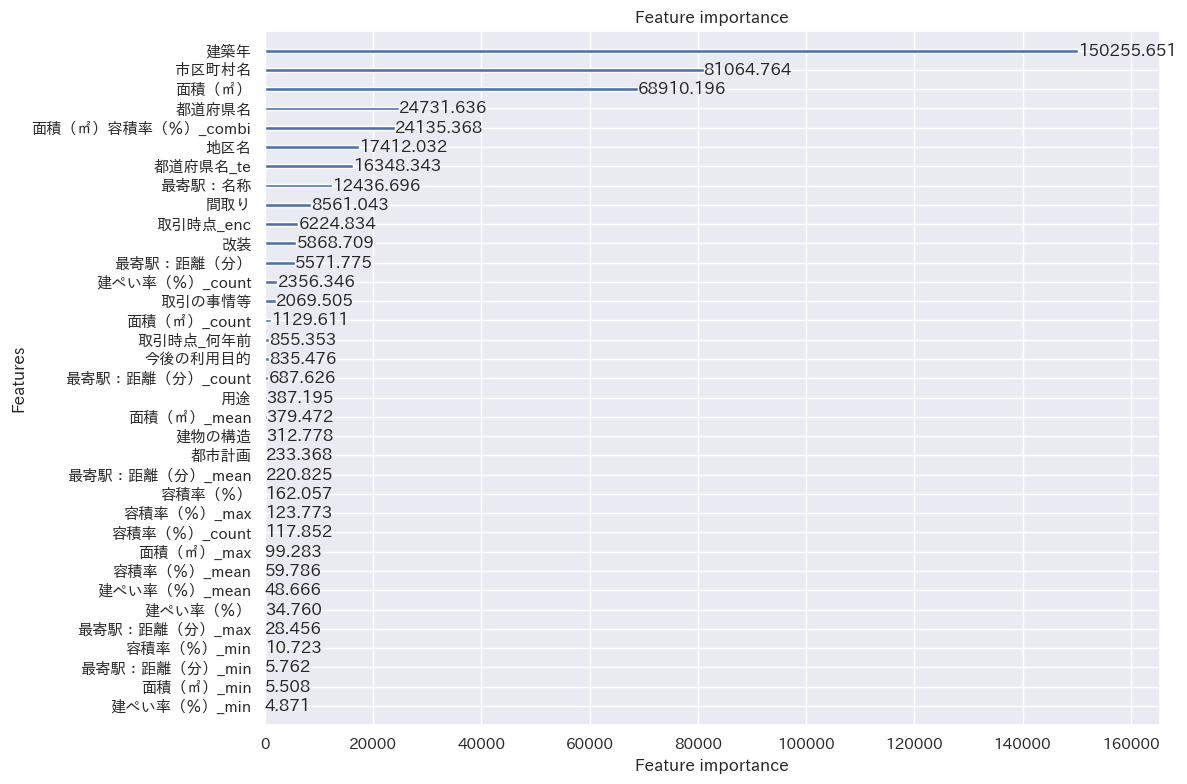

In [52]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(BASE_PATH + 'output/feature_importance.png')
plt.show()
plt.close()

## 推論

In [53]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)

In [55]:
test_df[TARGET] = test_pred

/tmp/ipykernel_1766/88504142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[TARGET] = test_pred


In [ ]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(BASE_PATH + 'output/tutorial_test_submission.csv', index=False)